In [ ]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from scipy.stats import norm

plt.rcParams['figure.figsize']=(5,5)
np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)
seed = 1460

# Modelos de mezclas de gaussianas

En el cuaderno anterior hemos asumido que todas las características (o al menos un grupo de dos o más de ellas) tienen un distribución conjunta MVN.

Si fuera así entonces todos los ejemplos se deberían concentrar en torno a un único valor, que es la media.

Sin embargo esto no siempre ocurre. Por ejemplo, en la figura de abajo se muestran los dos primeros componentes principales de los ejemplos de entrenamiento de la clase positiva en un problema de clasificación binaria. Como se puede ver, los ejemplos están agrupados en torno a tres puntos (centroides).

Si asumimos que tienen una única media y un modelo de verosimilitud MVN entonces estaremos creando una máquina con muy poco poder de predicción.


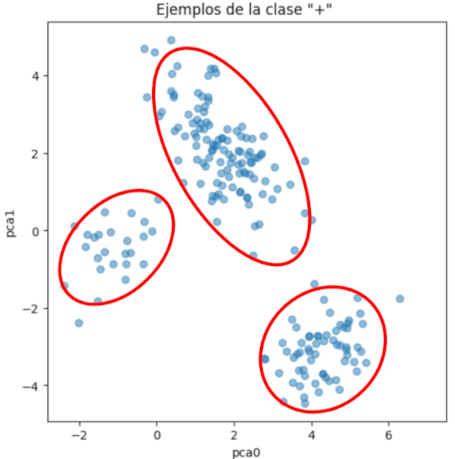

La alternativa es modelar la verosimilitud _mezclando_ varias distribuciones MVN.

En el caso de la figura tendríamos una _mezcla_ de 3 MVN, cada una con sus parámetros (media y matriz de covarianza).

**¿Qué es _mezclar_? ¿Por qué no podemos simplemente sumar las 3 MVN?**


## Definición de mezcla de gaussianas

Cualquier distribución de densidad de probabilidad debe cumplir que el área bajo la curva es igual a 1. <br>
Esto simplemente significa que la probabilidad de que ocurra un suceso posible, sea el que sea, es del 100%.
    

>    **Por ejemplo**:<br>
si decimos que la altura de todos los españoles tiene una densidad de probabilidad normal o gaussiana, centrada en 175 cm con desviación estandar de 20 cm,<br>
**¿Cuál es la probabilidad de encontrar un español cuya altura esté entre 0 cm y 300 cm?**<br>
Evidentemente, la probabilidad es del 100%.<br>
En el siguiente código podemos ver que el área bajo la curva de la PDF normal es efectivamente 1.

Área (aprox) bajo la curva normal = 0.99999


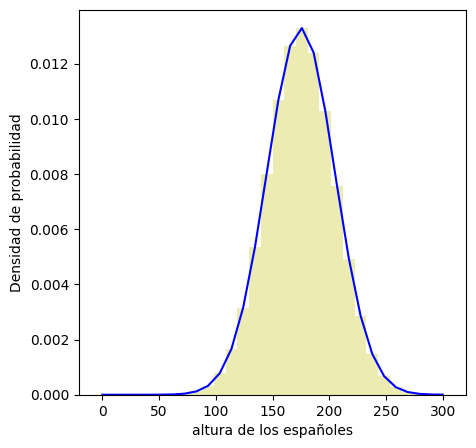

In [ ]:
#-- Parametros de una PDF normal
mu = 175    # media
sigma = 30  # desviación estandar

#-- Alturas posibles (entre 0 y 300 cm)
altura_min = 0
altura_max = 300
ns = 30
x = np.linspace(altura_min, altura_max, ns)
dx = x[1]-x[0]

#-- Dibujar la PDF de la altura de los españoles
prob_altura  = norm.pdf(x, loc=mu, scale=sigma)
plt.plot(x, prob_altura, 'b')
plt.xlabel('altura de los españoles')
plt.ylabel('Densidad de probabilidad')

#-- Aproximar el área bajo la curva con rectángulos
#   de altura = pdf(x) y anchura = dx
auc = np.sum(prob_altura) * dx
print(f'Área (aprox) bajo la curva normal = {auc:0.5f}')

#-- Dibujar el área bajo la curva con rectángulos
plt.bar(x,prob_altura, width=dx, color='y', alpha=0.3)

plt.show()


Por tanto, si simplemente sumaramos $N$ densidades normales, ¡¡ el área bajo la curva sería $N$ !!

**¿Y si dividimos por $1/N$?**

Si representamos $p_k(x; \mu_j, \Sigma_k)$ a una densidad MVN con media $\mu_k$ y matriz de covarianza $\Sigma_k$, entonces sumar $N$ y dividir por $1/N$ es lo mismo que decir que:
$$p_{\rm mezcla}(x) =
\frac{1}{N} p_1(x; \mu_1, \Sigma_1) +
\frac{1}{N} p_2(x; \mu_2, \Sigma_2) +
\frac{1}{N} p_3(x; \mu_3, \Sigma_3) +
\ldots $$

Efectivamente, el área bajo la curva de $p_{\rm mezcla}$ será 1, pero **¿por qué esos pesos para cada $p_k$?**

La siguiente expresión
$$
\begin{array}{l}
p_{\rm mezcla}(x) =
\pi_1 \cdot  p_1(x; \mu_1, \Sigma_1) +
\pi_2 \cdot  p_2(x; \mu_2, \Sigma_2) +
\pi_3 \cdot  p_3(x; \mu_3, \Sigma_3) + \ldots \\
{\rm siempre~que~~}
\pi_1  + \pi_2 + \pi_3 + \cdots = 1
\end{array}
$$

también genera una pdf válida, es decir con área bajo la curva = 1.

- $\pi_1, \pi_2, \pi_3, \cdots  \pi_K~$  son los coeficientes de la mezcla. <br>
Indican el porcentaja de la gaussiana que les acompaña utilizado en la mezcla.
- $p_k(x; \mu_k, \Sigma_k)$ se donomina _componente-MVN_ $k$-ésima de la mezcla de gaussianas; para $k=1\ldots K$.

<td bgcolor= "yellow"><h5>
  En definitiva, una <b>mezcla de gaussianas</b> es una <b>combinación convexa</b> de <b>componentes-MVN</b>.
</td>

$$
  p({\bf x} |y; {\bf w}) =
  \sum\limits_{i=1}^K {\pi_k}\cdot\text{MVN}({\bf x}|y; \mu_k, \Sigma_i),
  ~ \text{ tal que } \sum\nolimits_{i=1}^{K} \pi_i = 1.
$$
  
- _Combinación convexa_ significa que los coeficientes de la combinación son no negativos y suman 1.
- _Componentes-MVN_, son simplemente distribuciones MVN (multivariada normal).

Un modelo de verosimilitud construido mediante mezcla de gaussianas se denomina **GMM** (_Gaussian Mixture Models_).

# Aprendizaje

Ya sabemos que aprender un modelo de verosimilitud consiste en aprender los parámetros de la distribución que hemos elegido, o que estamos construyendo.

**¿Qué parámetros tenemos que aprender en una mezcla de $K$ componentes-MVN?**
- $\mu_1, ~ \Sigma_1~$: media y matriz de covarianza de la 1ª componente-MVN.
- $\mu_2, ~ \Sigma_2~$: media y matriz de covarianza de la 2ª componente-MVN.<br>
 $\vdots$
- $\mu_K, ~ \Sigma_K~$: media y matriz de covarianza de la Kª componente-MVN.
- $\pi_1,~ \pi_2,\ldots, \pi_K$ : pesos de cada componente-MVN.

En definitiva, hay $2K + K = 3K$ parámetros.

Pero los parámetros propios de cada componente-MVN y los pesos con los que cada una contribuye a la mezcla tienen una _naturaleza_ diferente, y no se pueden aprender al mismo tiempo

<td bgcolor= "cyan">
   <b>Recuerda que...</b>
</td>

vamos a construir un modelo de verosimilitud, es decir la $p(x|y)$. <br>
Es decir, en todo momento estaremos suponiendo que los ejemplos pertenecen todos a la misma clase.

<td bgcolor= "pink">
   <b>IMPORTANTE</b>
</td>

Un **error muy común** cuando se quiere aprender un GMM es pensar que tenemos que averiguar a cual de las componentes-MVN pertenece un ejemplo $x$.

En un GMM, un ejemplo $X$ "pertenece" a todas y cada una de las componentes-MVN.

Con el código de abajo se puede comprobar que cualquier punto $x \in \mathbb R$ "pertenece" las dos componentes gaussianas de la mezcla.

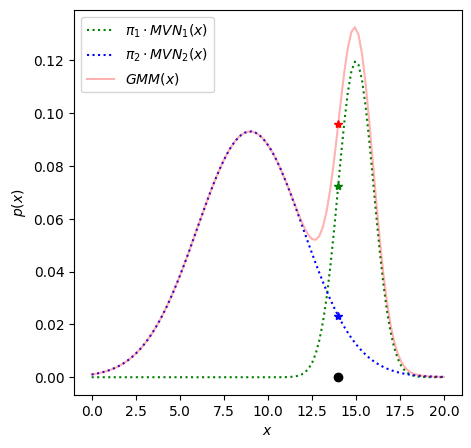

In [ ]:
#-- Parametros de una PDF normal
pi1 = 0.3
mu1 = 15    # media
sigma1 = 1  # desviación estandar
#
pi2 = (1-pi1)
mu2 = 9    # media
sigma2 = 3  # desviación estandar

#-- Alturas posibles (entre 0 y 300 cm)
altura_min = 0
altura_max = 20
ns = 100
x = np.linspace(altura_min, altura_max, ns)

#-- Dibujar la PDF de la altura de los españoles
prob1 = pi1 * norm.pdf(x,mu1, sigma1)
prob2 = pi2 * norm.pdf(x,mu2, sigma2)
prob_gmm = prob1 + prob2

plt.plot(x,prob1,':g', label='$\pi_1 \cdot MVN_1(x)$')
plt.plot(x,prob2,':b', label='$\pi_2 \cdot MVN_2(x)$')
plt.plot(x,prob_gmm, 'r', alpha=0.3, label='$GMM(x)$')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$p(x)$')

#-
x_choice = 14 #<-- Modificar este punto entre 0 y 20
P_mvn1 = pi1*norm.pdf(x_choice, mu1, sigma1)
P_mvn2 = pi2*norm.pdf(x_choice, mu2, sigma2)
P_gmm  = P_mvn1 + P_mvn2
plt.plot(x_choice,0,'ko')
plt.plot(x_choice,P_mvn1, 'g*' )
plt.plot(x_choice,P_mvn2, 'b*' )
plt.plot(x_choice,P_gmm, 'r*' )
plt.show()

Esta aclaración es importante porque para aprender los parámetros de una GMM necesitaremos calcular el **factor de pertenencia**, y ese nombre puede llevarnos a pensar erroneamente que los puntos pertenecen a una componente o a otra.

## Definición de _factor de pertenencia_

Definimos **factor de pertenencia** del ejemplo $i$-ésimo $~{\bf x}^{(i)}~$ a la $k$-ésima componente-MVN al valor

$$
\gamma_{i,k} = \frac{\pi_k\cdot\mathrm{MVN}_k({\bf x}^{(i)})}{\sum\limits_{i=1}^K \pi_k\cdot\mathrm{MVN}_k({\bf x}^{(i)})}
$$

- El numerador es simplemente evaluar el ejemplo en la componente-MVN
- El denominador es evaluar el ejemplo en la GMM.

> _En el ejemplo de arriba, el factor de pertenencia del punto negro a la componente azul se calcularía como la altura de la estrella azul divida por la altura de la estrella roja._

## Algoritmo EM

Este algoritmo consiste en alternar un paso **E** ("Esperanza", _"Expectation"_) donde se cálcula el factor de pertenencia para cada ejemplo, un paso **M** ("Maximización", _"Maximization"_), donde se actualizan los parámetros de la GMM.

### Paso "E"

Calcular el factor de pertenencia de cada uno de los ejemplos.<br>
Obtenemos una tabla de valores ${\rm\Gamma} = \{\gamma_{i,k}\}$ para $i=1\ldots N$, $k = 1\ldots K$; es decir una tabla de valores de pertenencia donde los ejemplos van en filas y las componentes-MVN en columnas.<br>
(Se verifica que  cada fila suma 1 )

### Paso "M"

1. Calcular $M_k = \sum_{i=1}^{N} \gamma_{i,k}$ <br>
   es decir la suma de la $k$-esima columna de la tabla ${\rm\Gamma}$, para $k=1\ldots K$.
2. Actualizar los $K$ pesos con la regla:
$$ \pi_k^{\rm nuevo} = M_k / N $$
3. Actualizamos la media y covarianza de cada MVN$_k$.
$$
\begin{align}
\mu^{\rm nuevo}_k &= \frac{1}{M_k}\sum\nolimits_{i=1}^{N} \left( \gamma_{i,k} \cdot{\bf x}^{(i)} \right)
\\
\Sigma^{\rm nuevo}_k  &= \frac{1}{M_k}\sum\nolimits_{i=1}^{N} \left( \gamma_{i,k}\cdot({\bf x}^{(i)}-\mu^{\rm nuevo}_k)({\bf x}^{(i)}-\mu^{\rm nuevo}_k)^\top \right)
\end{align}
$$

### Inicialización

Es fácil darse cuenta de que para hacer los cálculos del paso "E" necesitamos tener las $K$ MVN-componentes (que se actualizan en el paso "M"), mientras que para el paso "M" necesitamos tener el factor de pertenencia (que se actualiza en el paso "E").

**¿Entonces, cómo se inicializa el algoritmo?**

Se puede empezar de dos maneras:

- Inicializar de manera aleatoria un vector de $K$ pesos, así como una media y una matriz de covarianza para cada componente-MVN.<br>
$\rightarrow$ empezaríamos por el paso "E".
- Inicializar de manera aleatoria una tabla de valores $\Gamma$.<br>
$\rightarrow$ empezaríamos por el paso "M".

**¡¡Cuidado!!**<br>
en ambos casos hay que recordar que no sirve cualquier inicialización ya que:
$$
\begin{array}{cccc}
\sum_{k=1}^N \pi_k = 1 &
, &
\sum_{k=1}^N \gamma_{i,k} = 1.
\end{array}
$$

# Inferencia

Con GMM simplemente estamos aprendiendo un nuevo modelo de verosimilitud.

Para hacer inferencia debemos proceder exactamente igual que con Naive Bayes o con los modelos de Gaussinas. Esto significa que:
1. Debemos empezar modelando la distribución a priori
2. A continuación aprendemos el modelo de verosimilitud mediante GMM.

Una vez tenemos tanto $~p(y)~$  como $~p(x|y)~$ tomamos logaritmos; es decir
$$
\begin{array}{cccc}
\log p(y) &, &
\log p(x|y);
\end{array}
$$

y probamos con cada $~y~$ posible en la expresión

$$\arg\max \log p(y|x) = \arg\max \big( \log p(y) + \log p(x|y) \big). $$

# Ejemplo

En este ejemplo vamos a contruir un modelo de verosimilitud con mezcla de gaussianas para un problema de clasificación binario.

El conjunto de datos será muy sencillo, sólo con dos características para poder visualizar los ejemplos y el modelo. Para ello usaremos el método de Scikit-Learn `make_moons`.
Inmediatamente después de obtener los ejemplos, hacemos una separación de train y test.

In [ ]:
#%% -- Crear el conjunto de datos (de juguete) con la función `make_moons`
n_samples = 400
full_X, full_Y = make_moons(n_samples=n_samples, noise=0.2)
feature_names = ['x_1','x_2']
target_name = 'class'
full_X = pd.DataFrame(full_X, columns=feature_names)
full_Y = pd.DataFrame(full_Y, columns=[target_name])

<Axes: xlabel='x_1', ylabel='x_2'>

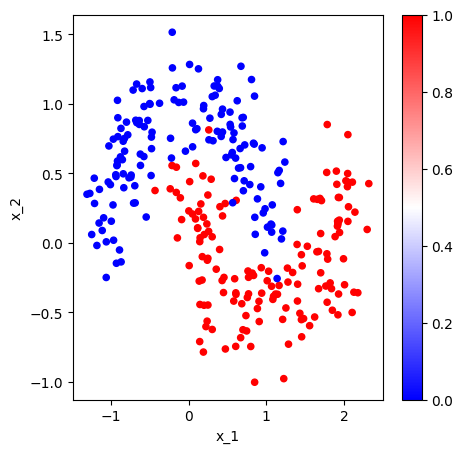

In [ ]:
#%% -- Separar el conjunto de datos en entrenamiento y test
test_size = 0.15
train_X, test_X, train_Y, test_Y = train_test_split(full_X, full_Y,
                                                    stratify = full_Y,
                                                    shuffle = True)
# - podemos ver el conjunto de datos de entrenamiento

train_X.plot(kind = 'scatter', x='x_1', y='x_2',
             c=train_Y[target_name].values, cmap='bwr')

Para este ejemplo asumiremos que el modelo **a priori** sobre la etiqueta es
$$p(y=0) = p(y=1) = 0.5$$

Por tanto sólo queda aprender el modelo de **verosimilitud**, que serán **GMM**.



In [ ]:
#%% -- Modelos de verosimilitud

#--- configuración común para cada modelo
n_components=2
covariance_type='full'
max_iter=15
random_state=seed

#--- modelo GMM para y=0
gmm0 = GaussianMixture(n_components=n_components,
                       covariance_type=covariance_type,
                       max_iter=max_iter,
                       random_state=random_state)
gmm0.fit(train_X[train_Y[target_name]==0])

#--- modelo GMM para y=1
gmm1 = GaussianMixture(n_components=n_components,
                       covariance_type=covariance_type,
                       max_iter=max_iter,
                       random_state=random_state)
gmm1.fit(train_X[train_Y[target_name]==1])

GaussianMixture(max_iter=15, n_components=2, random_state=1460)

Una vez aprendidos los modelos a priori y de verosimilitud podemos hacer inferencia.

En vez de utilizar el conjunto de test, vamos a probar con puntos dentro del intervalo $[-2,2]\times[-2,2]$; así podemos visualizar la superficie de separación.

Recordamos que la etiqueta predicha es
$$
\hat y = \mathop{\arg\max}\limits_y \big(\log p(y) + \log p(x|y) \big)
$$

In [ ]:
#%% -- Hacer inferencia sobre el intervalo [-2,2] x [-2,2]
# ¡¡ Asumimos que el modelo a priori es p(y=0)=p(y=1) !!

#- comenzamos haciendo un barrido de puntos
bound = 2
ns = 40
range_X1 = np.linspace(-bound, bound, ns)
range_X2 = np.linspace(-bound, bound, ns)
mesh_X1, mesh_X2 = np.meshgrid(range_X1, range_X2)
mesh_X1 = mesh_X1.reshape([ns*ns,1])
mesh_X2 = mesh_X2.reshape([ns*ns,1])
test_interval = np.concatenate([mesh_X1, mesh_X2], axis=1)
test_interval = pd.DataFrame(test_interval, columns=feature_names)

#- a continuación pedimos a cada modelo gmm su log-likelihood (método score_samples)
hat_p0 = gmm0.score_samples(test_interval).reshape([ns,ns])
hat_p1 = gmm1.score_samples(test_interval).reshape([ns,ns])

#-
hat_y  = 1*(hat_p0 < hat_p1)

Para terminar realizamos varias visualizaciones

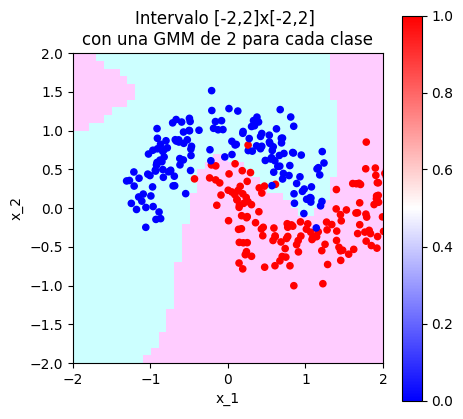

In [ ]:
#--- muestra de las zonas asignadas a cada clase.
#    la superficie de decisión es la frontera entre ambas
ax = train_X.plot(kind='scatter', x='x_1', y='x_2',
                  c=train_Y[target_name].values, cmap='bwr')
ax.imshow(hat_y, extent=[-bound, bound, -bound, bound], alpha=0.2, origin='lower', cmap='cool')
strTitle = f"Intervalo [-{bound},{bound}]x[-{bound},{bound}] \ncon una GMM de {n_components} para cada clase"
ax.set_title(strTitle)
plt.show()


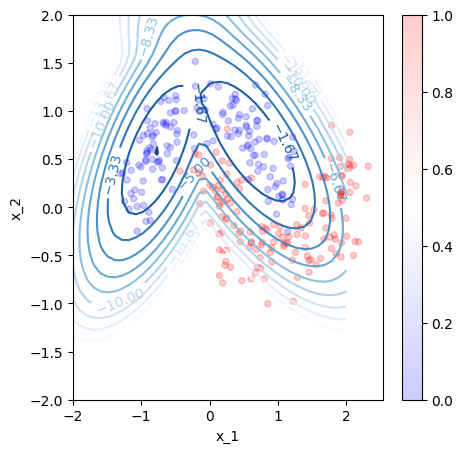

In [ ]:
#--- muestra de las "curvas de nivel" de la log-verosimilitud p(x|y=0)

train_X.plot.scatter(x='x_1', y='x_2',
                     c=train_Y[target_name].values, cmap='bwr', alpha=0.2)

strTitle = r"GMM con %d componentes"%(n_components)
ax.set_title(strTitle)
ax.axis('scaled')

clevels_0 = plt.contour(hat_p0, np.linspace(-15,0,10),
                        extent=[-bound, bound, -bound, bound],
                        cmap='Blues', alpha=0.9)
ax.clabel(clevels_0, clevels_0.levels)

plt.show()

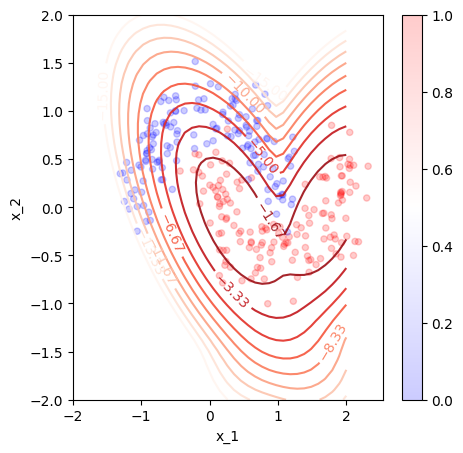

In [ ]:
#--- muestra de las "curvas de nivel" de la log-verosimilitud p(x|y=1)

train_X.plot.scatter(x='x_1', y='x_2',
                     c=train_Y[target_name].values, cmap='bwr', alpha=0.2)

strTitle = r"GMM con %d componentes"%(n_components)
ax.set_title(strTitle)
ax.axis('scaled')

clevels_1 = plt.contour(hat_p1, np.linspace(-15,0,10),
                        extent=[-bound, bound, -bound, bound],
                        cmap='Reds', alpha=0.9)
ax.clabel(clevels_1, clevels_1.levels)

plt.show()

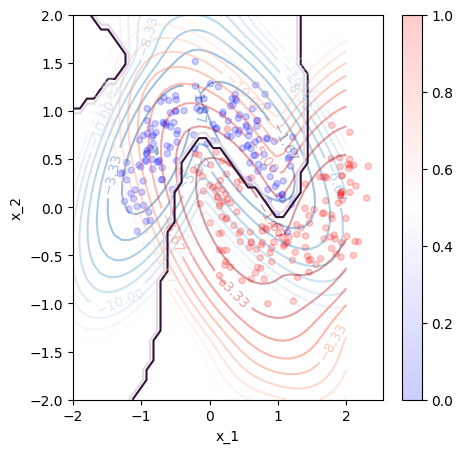

In [ ]:
#--- muestra de la superficie de decisión como la unión de los puntos
#    donde las curvas de nivel de cada modelo tienen la misma altura

train_X.plot.scatter(x='x_1', y='x_2',
                     c=train_Y[target_name].values, cmap='bwr', alpha=0.2)

strTitle = r"GMM con %d componentes"%(n_components)
ax.set_title(strTitle)
ax.axis('scaled')

clevels_0 = plt.contour(hat_p0,np.linspace(-15,0,10),extent=[-bound, bound, -bound, bound],cmap='Blues', alpha=0.4)
ax.clabel(clevels_0, clevels_0.levels)
clevels_1 = plt.contour(hat_p1,np.linspace(-15,0,10),extent=[-bound, bound, -bound, bound],cmap='Reds', alpha=0.4)
ax.clabel(clevels_1, clevels_1.levels)
plt.contour(hat_y,1,extent=[-bound, bound, -bound, bound],cmap='twilight', alpha=1)
plt.rcParams['figure.figsize'] = [6,6]

plt.show()

Por último podemos mostrar los parámetros de cada modelo

In [ ]:
def print_gmm_info(gmm):
  print('\nweights:')
  print(gmm.weights_)
  #
  print('\nmeans:')
  print(gmm.means_)
  #
  print('\ncovariances:')
  print(gmm.covariances_)

# --------------------------
print('\n**** GMM(x|y=0)  ****')
print_gmm_info(gmm0)
print('\n**** GMM(x|y=1) ****')
print_gmm_info(gmm1)


**** GMM(x|y=0)  ****

weights:
[0.49 0.51]

means:
[[-0.78  0.59]
 [ 0.61  0.68]]

covariances:
[[[ 0.08  0.06]
  [ 0.06  0.13]]

 [[ 0.14 -0.09]
  [-0.09  0.13]]]

**** GMM(x|y=1) ****

weights:
[0.52 0.48]

means:
[[ 0.38 -0.13]
 [ 1.7  -0.07]]

covariances:
[[[ 0.13 -0.08]
  [-0.08  0.16]]

 [[ 0.11  0.07]
  [ 0.07  0.14]]]


# Ejercicios

Modifica el código para que:
1. en el conjunto de datos haya dos veces más ejemplos de la clase 0 que de la clase 1.
2. se incorpore un modelo a priori que capture el desequilibro de ejemplos de cada clase
3. realiza una estimación MAP (_Maximo A Posteriori_) de la etiqueta para los puntos del intervalo $[-2,2]\times[-2,2]$ pero utilizando el modelo a priori del punto anterior y GMMs de 3 componentes-MVN.